## Ball Picking Challenge

### Part 2: Pick and Place

The aim is to program the robot for the second part of the challenge: pick up the balls and transport them to the corner. To do so, you need to reuse the abilities learnt in week 4; please feel free to reuse the code of those notebooks and exercises.

In [1]:
import packages.initialization
import pioneer3dx as p3dx
p3dx.init()
import cv2
import numpy
## Find blob
def color_blob():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    M = cv2.moments(mask)
    area = M['m00']
    if area > 0:
        cx = int(M['m10']/area)
        cy = int(M['m01']/area)
    else:
        cx = None
        cy = None
    return area, cx, cy
## True if blob is centered
def is_blob_centered(color):
    area, cx, cy = color_blob()
    if color == 'blue':
        b = blue_balls()
        if len(b) > 0:
            cx = b[0][1]
    if area > 0 and cx >= 72 and cx < 78:
        return True
    else:
        return False
## True if blob is close
def is_blob_close(dist):
    area, cx, cy = color_blob()
    if dist > 0:
        b = blue_balls()
        if len(b) > 0:
            cy = b[0][2]
    if area > 0 and cy >= dist:
        return True
    else:
        return False
## Find blue balls
def blue_balls():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower_blue = numpy.array([110,  50,  50])
    upper_blue = numpy.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 5
    detector = cv2.SimpleBlobDetector(params)
    reversemask = 255-mask
    keypoints = detector.detect(reversemask)
    l = []
    for i,kp in enumerate(keypoints):
        l.append((kp.size,) + kp.pt)
    l.sort(key=lambda tup: tup[0], reverse=True)
    return l
## Find red region
def red_detected():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower = numpy.array([170, 100, 50])
    upper = numpy.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    M = cv2.moments(mask)
    area = M['m00']
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        return True
    else:
        cx, cy = 0, 0
        return False
## True if too close to object
def is_obstacle_detected():
    dist = min(p3dx.distance[0:])
    if  dist > 0.4:
        return False
    else:
        return True
## Follow wall
def getWall():
    leftSide = min(p3dx.distance[0:3])
    frontSide = min(p3dx.distance[3:5])
    rightSide = min(p3dx.distance[5:])
    if leftSide > rightSide:
        while rightSide < 0.6:
            p3dx.move(-1,-0.5)
            p3dx.sleep(0.5)
            rightSide = min(p3dx.distance[3:5])
    else:
        while leftSide < 0.6:
            p3dx.move(-0.5,-1)
            p3dx.sleep(0.5)
            leftSide = min(p3dx.distance[3:5])
## Make sure no ball is outside of red zone
def noball():
    if sweep and red_detected():
        return True
    else:
        return False
## Detect green zone to avoid
def green_detected():
    width = p3dx.image.shape[1]
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower_grn = numpy.array([40, 100, 50])
    upper_grn = numpy.array([80, 255, 255])
    mask = cv2.inRange(hsv, lower_grn, upper_grn)
    mask[0:80, 0:150] = 0
    M = cv2.moments(mask)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        return True
    else:
        cx, cy = 0, 0
        return False

Found ROS controller /pioneer3dx_17964_ip_172_31_42_174


In [ ]:
p3dx.sleep(3)
try:
    i = 0
    while True:
        i = i+1;
        sweep = True
        print('Iteration', i)
        ## Find ball and approach
        lower = numpy.array([110, 50, 50])
        upper = numpy.array([130, 255, 255])
        p3dx.gripper(0.05,0.1)
        p3dx.tilt(0)
        p3dx.sleep(2)

        print('Turn')
        try:
            while not is_blob_centered('blue') and not red_detected():
                p3dx.move(-1,1)
            p3dx.stop()
            while not is_blob_centered('blue') or green_detected():
                p3dx.move(-0.5,0.5)
            p3dx.stop()
        except noball():
            p3dx.stop()

        while not is_blob_close(80):
            p3dx.move(2,2)
        p3dx.stop()

        print('Tilt')
        p3dx.tilt(-0.47)
        p3dx.sleep(2)
        while not is_blob_centered('blue'):
            p3dx.move(0.5,-0.5)
        p3dx.stop()
        while not is_blob_close(85):
            p3dx.move(1,1)
        p3dx.stop()
        p3dx.move(0.5,0.5)
        p3dx.sleep(1)
        p3dx.stop()

        print('Close')
        ## Pickup the ball
        p3dx.gripper(0.05,0)
        p3dx.sleep(1)
        p3dx.gripper(-0.05,0)
        p3dx.sleep(1)
        
        sweep = False
        ## Find red and approach
        lower = numpy.array([170, 100, 50])
        upper = numpy.array([180, 255, 255])
        p3dx.tilt(0)
        p3dx.sleep(2)
        print('Turn')
        while not is_blob_centered('red'):
            p3dx.move(-1,1)
        p3dx.stop()  
        print('Approach Red')
        while not is_blob_close(90):
            if is_obstacle_detected():
                getWall()
            p3dx.move(5,5)

        p3dx.move(1,1)
        p3dx.sleep(3)
        p3dx.stop()

        ## Drop the ball
        p3dx.sleep(1)
        p3dx.gripper(0.05,0)
        p3dx.gripper(0.05,1)
        print('Drop')
        p3dx.move(-2,-2)
        p3dx.sleep(5)
        p3dx.stop()

        while red_detected():
            p3dx.move(-1,1)
        p3dx.stop()

except KeyboardInterrupt:
    p3dx.stop()

('Iteration', 1)
Turn
Tilt
Close
Turn
Approach Red
Drop
('Iteration', 2)
Turn
Tilt
Close
Turn
Approach Red
Drop
('Iteration', 3)
Turn
Tilt
Close
Turn
Approach Red


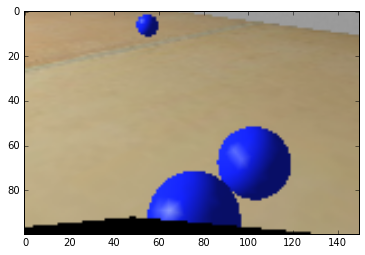

In [8]:
## Test Camera
p3dx.tilt(-0.47)
p3dx.sleep(2)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(p3dx.image);

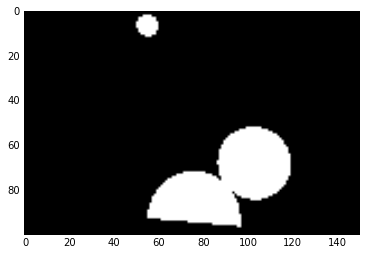

In [9]:
import cv2
import numpy
hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
lower = numpy.array([110, 50, 50])
upper = numpy.array([130, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
plt.imshow(mask,cmap='gray');

---
#### Try-a-Bot: an open source guide for robot programming
Developed by:
[![Robotic Intelligence Lab @ UJI](img/logo/robinlab.png "Robotic Intelligence Lab @ UJI")](http://robinlab.uji.es)

Sponsored by:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="http://www.ieee-ras.org"><img src="img/logo/ras.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.cyberbotics.com"><img src="img/logo/cyberbotics.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.theconstructsim.com"><img src="img/logo/theconstruct.png"></a>
</td>
</tr>
</table>

Follow us:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="https://www.facebook.com/RobotProgrammingNetwork"><img src="img/logo/facebook.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="https://www.youtube.com/user/robotprogrammingnet"><img src="img/logo/youtube.png"></a>
</td>
</tr>
</table>